In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import scipy.stats as stats

from dask.distributed import Client

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
import utils.caching
from utils.caching import make_cached
from utils.parallel import get_map_parallel_joblib, parallelise_for_unique
from utils.paths import GENERATED_DATA_PATH
from utils.plotting import highlight_points

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
cached = make_cached(GENERATED_DATA_PATH)

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

In [7]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [8]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_samples(i) -> np.ndarray:
    raise NotImplementedError

In [9]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def hmc_samples(i) -> np.ndarray:
    raise NotImplementedError

In [10]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_thinned_idx(i) -> np.ndarray:
    raise NotImplemented

In [11]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def validation_hmc_samples(i) -> np.ndarray:
    raise NotImplemented

In [12]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_log_p(i) -> np.ndarray:
    raise NotImplemented

In [13]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def hmc_log_p(i) -> np.ndarray:
    raise NotImplemented

In [14]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/validation_hmc_samples_4

# Gradient-free Stein thinning

In [15]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

## Full sample

### Student t proxy

In [16]:
from scipy.optimize import OptimizeResult
from scipy.special import gamma

In [17]:
def extract_t_params(par, d):
    # upper-triangular elements of an n-by-n matrix
    n_cov = d * (d + 1) // 2

    # the means of the multivariate t are in the first `d` elements
    mu = par[:d]
    # the upper triangular elements of A are in the following `n_cov` elements
    A = np.zeros((d, d))
    A[np.triu_indices(d)] = par[d:d + n_cov]
    # the scale matrix
    scale = A.T @ A
    # the degrees of freedom value is the last element of `par`
    df = par[d + n_cov]

    return mu, scale, df

def fit_mvt(
        Y: np.ndarray,
        mu_bounds: tuple[float, float],
        a_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu_init: np.ndarray = None,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables
    n_cov = d * (d + 1) // 2  # upper-triangular elements of an n-by-n matrix

    # the starting values for the search
    if mu_init is None:
        mu_init = np.mean(Y, axis=0)
    sample_cov = np.cov(Y, rowvar=False, ddof=d)
    A = np.linalg.cholesky(sample_cov).T
    start = np.concatenate([mu_init, A[np.triu_indices(d)], [df_init]])

    # the bounds for the search
    lower = np.array([mu_bounds[0]] * d + [a_bounds[0]] * n_cov + [df_bounds[0]])
    upper = np.array([mu_bounds[1]] * d + [a_bounds[1]] * n_cov + [df_bounds[1]])

    def loglik_mvt(Y: np.ndarray, par: np.ndarray) -> float:
        mu, scale, df = extract_t_params(par, Y.shape[1])
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=scale, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta)

    bounds = list(zip(lower, upper))

    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

def fit_mvt2(
        Y: np.ndarray,
        scale_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu: np.ndarray,
        scale_init: float = 0.0,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables

    # the starting values for the search
    sample_cov = np.cov(Y, rowvar=False, ddof=d)

    def loglik_mvt(Y: np.ndarray, scale, df) -> float:
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=np.exp(scale) * sample_cov, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta[0], beta[1])

    bounds = [scale_bounds, df_bounds]

    start = np.array([scale_init, df_init])
    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

In [18]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_t_fit(i) -> OptimizeResult:
    return fit_mvt(rw_samples[i], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 15), df_init=3.)

Force recalculation when necessary:

In [19]:
%%time
map_parallel(rw_t_fit.get_or_recalculate, range(lotka_volterra.n_chains));

CPU times: user 46.5 ms, sys: 75 ms, total: 122 ms
Wall time: 2.09 s


In [20]:
%%time
fit = fit_mvt(rw_samples[0], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 30), df_init=4.)
fit

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_samples_0.npy


CPU times: user 13min 55s, sys: 58.2 s, total: 14min 54s
Wall time: 3min 47s


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -8155728.166535322
        x: [-3.826e-01  2.920e-01 ...  2.805e-03  1.296e+01]
      nit: 279
      jac: [ 2.660e+04  2.230e+03 ... -2.135e+04  1.723e+01]
     nfev: 4928
     njev: 308
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>

In [21]:
t_mu, t_scale, t_df = extract_t_params(fit.x, lotka_volterra.d)

The density of the multivaritate Student's t distribution is given by
$$f(\mathbf{x}) = \frac{\Gamma\left(\frac{\nu + d}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \nu^{\frac{d}{2}} \pi^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}} \left[1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})\right]^{-\frac{\nu + d}{2}}.$$
The gradient of the log-density is then
$$\nabla_{\mathbf{x}} \log f(\mathbf{x}) = -\frac{\nu + d}{\nu} \frac{\Sigma^{-1} (\mathbf{x} - \pmb{\mu})}{1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})}$$

We implement the log-density of the multivariate t and confirm that it matches what is returned by `scipy`:

In [22]:
def t_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    return (
        np.log(gamma((df + d) / 2))
        - np.log(gamma(df  / 2))
        - d * (np.log(df) + np.log(np.pi)) / 2
        - np.log(np.linalg.det(sigma)) / 2
        -(df + d) / 2 * np.log(1 + np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu) / df)
    )

In [23]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=t_scale, df=t_df)

In [24]:
np.testing.assert_allclose(t_log_pdf(rw_samples[0], t_mu, t_scale, t_df), log_q)

In [25]:
def t_grad_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    direction_scaled = np.einsum('jk,ik->ij', sigma_inv, x_mu)
    mahalanobis_d = np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu)
    return -(df + d) / df / (1 + mahalanobis_d / df).reshape(-1, 1) * direction_scaled

In [26]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=t_scale, df=t_df)
gradient_q = t_grad_log_pdf(rw_samples[0], t_mu, t_scale, t_df)
thin_gf(rw_samples[0], rw_log_p[0], log_q, gradient_q, 100, range_cap=200)

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_log_p_0.npy
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/stein_thinning/thinning.py:126: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([268793, 193321, 490046, 149313, 162706, 164955, 136691,  84332,
       392297, 269558, 309148,  58196, 388084, 122231, 309276, 495415,
       199801, 313131,  51063, 368196, 166659, 344310, 465968, 427710,
       428061, 180763, 430204,  75114, 360185, 431345, 428177, 458015,
       316013, 304288, 392626, 268433, 400147,  32673, 427630, 466623,
       136691, 161876, 189684, 366525, 149330, 136559, 309297, 269441,
       331751, 203852, 127436, 452156, 355865, 412784, 462435, 269287,
        63688,  16713, 209119,  43690, 149670, 268927, 133800, 399991,
       118687, 134805, 136691, 392030, 269100, 149290, 428392, 126299,
        38346,   1413, 135543,  23613, 365032, 144040, 239885,  38881,
       478181, 165838, 287964, 470265, 103330, 331069, 283468, 162790,
       374696,  46093, 378373, 218004, 360281, 427873, 133047, 319866,
        13502, 170739, 416193, 485387], dtype=uint32)

In [27]:
np.ptp(log_q - rw_log_p[0])

np.float64(15570.621323719202)

In [28]:
sample_mode = rw_samples[0][np.argmax(rw_log_p[0])]
fit2 = fit_mvt2(rw_samples[0], scale_bounds=(-20, 20), df_bounds=(2, 30), mu=sample_mode)
fit2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -7701532.929604809
        x: [-6.643e-01  9.456e+00]
      nit: 12
      jac: [-4.657e-01  9.313e-02]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [29]:
t_mu = sample_mode
t_scale = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d) * np.exp(fit2.x[0])
t_df = fit2.x[1]

In [30]:
t_mu

array([-0.38262152,  0.2922964 , -0.01989471, -0.01783209])

In [31]:
t_scale

array([[ 1.09611960e-04,  8.38838465e-05, -9.86239022e-05,
        -8.86946687e-05],
       [ 8.38838465e-05,  1.01512842e-04, -5.26867766e-05,
        -3.28134021e-05],
       [-9.86239022e-05, -5.26867766e-05,  1.11649823e-04,
         1.09800008e-04],
       [-8.86946687e-05, -3.28134021e-05,  1.09800008e-04,
         1.18833878e-04]])

In [32]:
t_df

np.float64(9.456162110679575)

In [33]:
t_df = np.round(t_df)
t_df

np.float64(9.0)

In [34]:
def thin_gf_t(sample, log_p, t_mu, t_scale, t_df, thinned_size):
    log_q = stats.multivariate_t.logpdf(sample, loc=t_mu, shape=t_scale, df=t_df)
    gradient_q = t_grad_log_pdf(sample, t_mu, t_scale, t_df)
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size, range_cap=200)

In [35]:
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d)

In [36]:
idx = thin_gf_t(rw_samples[0], rw_log_p[0], t_mu, sample_cov * 3, 4, 100)
idx

array([210376, 442969,  80507,  51956, 392030,  55794, 249886, 428495,
       284066, 397477,  58914, 113015,  19535, 341822, 349159, 430931,
       245786, 222623, 279220, 465968, 437304, 499762,  97484, 285752,
       318398, 366902, 392297, 173240, 192217, 246329,  32814, 430204,
       456038, 131209, 396729, 297862, 372321, 289076, 378348, 283826,
       215531, 274665, 236412, 411800, 493992, 164977, 449619, 464124,
       271127, 301248,  69014, 264791,  58495, 478448, 471186, 490046,
       396803, 359110, 468104, 439100, 160255, 317689, 142635, 413010,
       238704, 218919, 411041, 106757, 387864, 476932, 149313, 247965,
       387974, 433207, 139123, 474510, 259443, 418138, 430931,  92115,
        98812, 320672,  31205,  22933,  39812, 337220,  34004, 129779,
       269834, 460980, 465955, 115317, 325680, 389154, 311114, 141151,
       439171,  43873, 199242, 147363], dtype=uint32)

In [37]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=sample_cov * 3, df=4)
gradient_q = t_grad_log_pdf(rw_samples[0], t_mu, sample_cov * 3, lotka_volterra.d)
thin_gf(rw_samples[0], rw_log_p[0], log_q, gradient_q, 100, range_cap=200)

array([210376, 442969,  80507,  51956, 392030,  55794, 249886, 428495,
       284066, 397477,  58914, 113015,  19535, 341822, 349159, 430931,
       245786, 222623, 279220, 465968, 437304, 499762,  97484, 285752,
       318398, 366902, 392297, 173240, 192217, 246329,  32814, 430204,
       456038, 131209, 396729, 297862, 372321, 289076, 378348, 283826,
       215531, 274665, 236412, 411800, 493992, 164977, 449619, 464124,
       271127, 301248,  69014, 264791,  58495, 478448, 471186, 490046,
       396803, 359110, 468104, 439100, 160255, 317689, 142635, 413010,
       238704, 218919, 411041, 106757, 387864, 476932, 149313, 247965,
       387974, 433207, 139123, 474510, 259443, 418138, 430931,  92115,
        98812, 320672,  31205,  22933,  39812, 337220,  34004, 129779,
       269834, 460980, 465955, 115317, 325680, 389154, 311114, 141151,
       439171,  43873, 199242, 147363], dtype=uint32)

In [38]:
np.ptp(log_q - rw_log_p[0])

np.float64(15622.255019308805)

In [39]:
def fit_quality(subsample, validation_sample_step=10):
    return np.sqrt(dcor.energy_distance(validation_sample[::validation_sample_step], subsample))

In [40]:
fit_quality(rw_samples[0][rw_thinned_idx[0][:100]])

DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_thinned_idx_0.npy


np.float64(0.10820419160264824)

In [41]:
fit_quality(rw_samples[0][idx[:100]])

np.float64(0.09470119350105072)

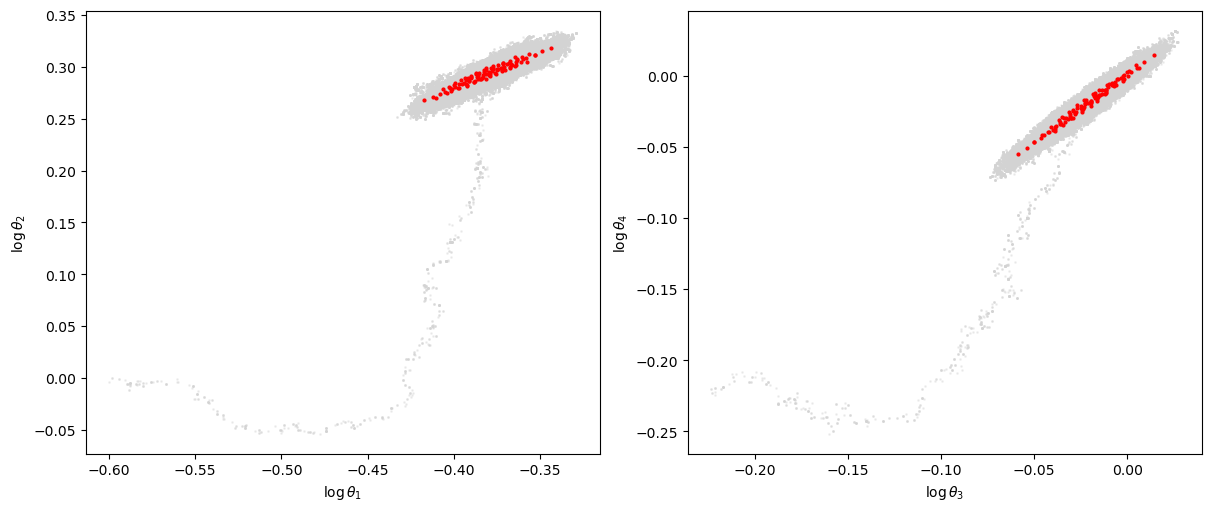

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

In [43]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_gf_t_idx(i) -> np.ndarray:
    t_mu, t_scale, t_df = extract_t_params(rw_t_fit[i].x, lotka_volterra.d)
    return thin_gf_t(rw_samples[i], rw_log_p[i], t_mu, t_scale, t_df, n_points_calculate)

In [44]:
map_parallel(rw_gf_t_idx.get_or_recalculate, range(lotka_volterra.n_chains));

In [45]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_gf_t2_idx(i) -> np.ndarray:
    sample_mode = rw_samples[i][np.argmax(rw_log_p[i])]
    sample_cov = np.cov(rw_samples[i], rowvar=False, ddof=lotka_volterra.d)
    return thin_gf_t(rw_samples[i], rw_log_p[i], sample_mode, sample_cov * 3, 4, n_points_calculate)

In [46]:
map_parallel(rw_gf_t2_idx.get_or_recalculate, range(lotka_volterra.n_chains));

Notebook execution took:

In [47]:
time.time() - start_time

276.86575841903687